In [1]:
# imports
from pyimagesearch.learningratefinder import LearningRateFinder
from pyimagesearch.clr_callback import CyclicLR
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD
from wandb.keras import WandbCallback
from pyimagesearch import config
from utils import data_utils
import tensorflow as tf
import numpy as np
import wandb
import time

The `pyimagesearch` module comes from our tutorial [Keras Learning Rate Finder](https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/). 

In [2]:
# fix random seed for better reproducibility
tf.random.set_seed(666)

In [3]:
# don't change this
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

In [4]:
# define the constants
BATCH_SIZE = 32
EPOCHS = 20

In [5]:
# let's load up the tfrecord filenames
tfr_pattern_train = "train_tfr/*.tfrec"
train_filenames = tf.io.gfile.glob(tfr_pattern_train)
tfr_pattern_test = "test_tfr/*.tfrec"
test_filenames = tf.io.gfile.glob(tfr_pattern_test)

In [6]:
# create the train and test dataset
training_dataset, steps_per_epoch = data_utils.batch_dataset(train_filenames, BATCH_SIZE, True)
validation_dataset, validation_steps = data_utils.batch_dataset(test_filenames, BATCH_SIZE, False)

In [7]:
# create a utility function to define our model
def create_model(img_size=(224,224), num_class=5, train_base=True):
    input_layer = Input(shape=(img_size[0],img_size[1],3))
    base = VGG16(input_tensor=input_layer,
                    include_top=False,
                    weights="imagenet")
    base.trainable = train_base
    x = base.output
    x = GlobalAveragePooling2D()(x)
    
    preds = Dense(num_class, activation="softmax")(x)
    return Model(inputs=input_layer, outputs=preds)

In [9]:
# instantiate the model, supply the loss scaled optimizer,
# and compile it
model = create_model()
opt = SGD(learning_rate=config.MIN_LR)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

**Brief steps to find a learning rate range**:

![](https://i.ibb.co/J3LjtNS/Screen-Shot-2019-12-08-at-9-55-29-AM.png)
<center><a href="https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/">Credits</a></center>

In [10]:
# use the learning rate finder to find a suitable range 
# to train our network
lrf = LearningRateFinder(model)
lrf.find(
    training_dataset,
    1e-10, 1e+1,
    stepsPerEpoch=steps_per_epoch,
    batchSize=config.BATCH_SIZE)

Epoch 1/22
97/97 [==============================] - 72s 746ms/step - loss: 1.9282 - accuracy: 0.2126
Epoch 2/22
97/97 [==============================] - 63s 646ms/step - loss: 1.9040 - accuracy: 0.2213
Epoch 3/22
97/97 [==============================] - 63s 648ms/step - loss: 1.9297 - accuracy: 0.2101
Epoch 4/22
97/97 [==============================] - 63s 646ms/step - loss: 1.9216 - accuracy: 0.2155
Epoch 5/22
97/97 [==============================] - 63s 647ms/step - loss: 1.9093 - accuracy: 0.2197
Epoch 6/22
97/97 [==============================] - 63s 647ms/step - loss: 1.9284 - accuracy: 0.2130
Epoch 7/22
97/97 [==============================] - 63s 647ms/step - loss: 1.9202 - accuracy: 0.2120
Epoch 8/22
97/97 [==============================] - 63s 647ms/step - loss: 1.9100 - accuracy: 0.2226
Epoch 9/22
97/97 [==============================] - 63s 646ms/step - loss: 1.9170 - accuracy: 0.2136
Epoch 10/22
97/97 [==============================] - 63s 646ms/step - loss: 1.8906 - accura

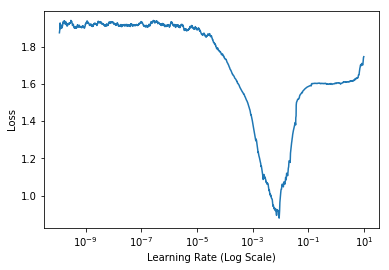

In [11]:
# let's plot the learning rates
lrf.plot_loss()

In [8]:
# initialize wandb
wandb.init("ml-bootcamp")

W&B Run: https://app.wandb.ai/sayakpaul/ML-Bootcamp-Launchpad/runs/x2ckud9w

In [9]:
# instantiate the model, supply the loss scaled optimizer,
# and compile it
model = create_model()
opt = SGD(learning_rate=config.MIN_LR)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [10]:
# compute the step size and initialize the cyclic learning
# rate method
step_size = config.STEP_SIZE * steps_per_epoch
clr = CyclicLR(
	mode=config.CLR_METHOD,
	base_lr=config.MIN_LR,
	max_lr=1e-3,
	step_size=step_size)

In [11]:
# train the network with CLR
start = time.time()
model.fit_generator(training_dataset, 
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[clr, WandbCallback(data_type="image", labels=CLASSES)])
wandb.log({"training_time": time.time() - start})

Epoch 1/20
97/97 [==============================] - 78s 807ms/step - loss: 1.8283 - accuracy: 0.2123 - val_loss: 1.6832 - val_accuracy: 0.2059
Epoch 2/20
97/97 [==============================] - 68s 697ms/step - loss: 1.5925 - accuracy: 0.2458 - val_loss: 1.5165 - val_accuracy: 0.3511
Epoch 3/20
97/97 [==============================] - 68s 700ms/step - loss: 1.4599 - accuracy: 0.4117 - val_loss: 1.3459 - val_accuracy: 0.4596
Epoch 4/20
97/97 [==============================] - 68s 698ms/step - loss: 1.2314 - accuracy: 0.5319 - val_loss: 0.9411 - val_accuracy: 0.6857
Epoch 5/20
97/97 [==============================] - 68s 698ms/step - loss: 0.9061 - accuracy: 0.6604 - val_loss: 0.6441 - val_accuracy: 0.7978
Epoch 6/20
97/97 [==============================] - 68s 698ms/step - loss: 0.7531 - accuracy: 0.7245 - val_loss: 0.5293 - val_accuracy: 0.8143
Epoch 7/20
97/97 [==============================] - 68s 697ms/step - loss: 0.6248 - accuracy: 0.7703 - val_loss: 0.4384 - val_accuracy: 0.8566